# Energy storage convex loss model

Objective: explore the *possibilities* to have convex loss models (i.e. $P_{losses}(...)$ below):

$$E_b(k+1) = E_b(k) + (P_b(k) - P_{losses}(P_b, E_b)) \Delta_t$$

Reminder: to preserve convexity, we need to replace the equality constraint with an **inequality**:

$$ E_b(k+1) ≤ ...$$

Next step: explore the interest of such models in some ESS optimization use cases:

- arbitrage
    - with optimal power split between two batteries with different losses curves ?


Also, maybe the same reasoning applies to model battery aging?

$$A(k+1) = A(k) + f(P,E)$$

PH, May 2020

In [2]:
import sympy
from sympy import symbols, Function, Matrix, simplify

In [3]:
sympy.init_printing()

In [143]:
e = symbols('e', positive=True) # we are interested in the positive domain e = SoE - SoE_singular (below)
p = symbols('p')

Re = Function('R')(e)
Rep = Function('R')(e,p)

Losses: Joule model, dependent on SoE

In [144]:
losses = Re*p**2
losses

Gradient

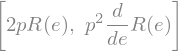

In [145]:
x = [p, e]
grad = [losses.diff(xi) for xi in x]
grad

Hessian

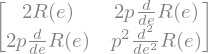

In [146]:
H = [[losses.diff(xi).diff(xj) for xi in x] for xj in x]
H = Matrix(H)
H

Eigen values

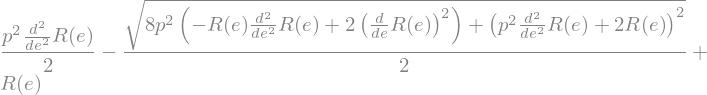

In [147]:
λ1,λ2 =  H.eigenvals().keys()
λ1

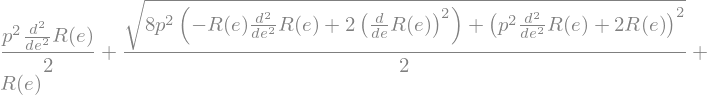

In [148]:
λ2

For the positivity, the first eigen value (λ1) may be critical

**TODO**: solve $λ ≥ 0$ for the general function R(e)

## Try with an affine R(e) function

In [149]:
r0, r1 = symbols('r_0 r_1')
Rlin = r0 + r1*e
Rlin

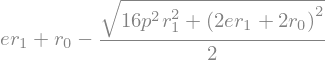

In [150]:
λ1_lin = simplify(λ1.subs(Re, Rlin))
λ1_lin

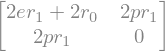

In [151]:
simplify(H.subs(Re, Rlin))

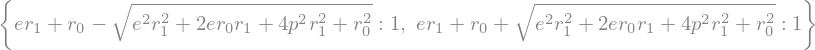

In [152]:
simplify(H.subs(Re, Rlin)).eigenvals()

## Try with a negative power R(e) function

$$R(e) = \frac{1}{e^a}$$

Conclusion as of May 14 2020 (to be prooved with a better pen and paper analysis of the eigenvalue):
- convex function for $a \in [0,1]$
- *quasi*-convex but not convex for $a \in [1,2]$ (cf. §3.4 in Boyd 2004 book)
- not even quasi convex for $a≥2$ (sublevel sets not convex)

Defintion:

A function f : R n → R is called quasiconvex (or unimodal ) if its domain and all its *sublevel sets*

$$ S_α = \{x ∈ \mathbf{dom} f \;| \; f(x) ≤ α \},$$

for α ∈ R, are convex.

In [153]:
a = symbols('a')
Rpow = 1/e**a
Rpow

Hessian with the power R(e) function

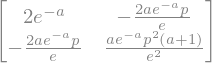

In [156]:
Hpow = simplify(H.subs(Re, Rpow))
Hpow

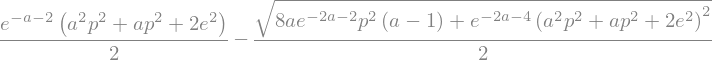

In [157]:
λ1pow,_ = Hpow.eigenvals().keys()
λ1pow

Subcase: $a=1$:

$$λ = 0$$

although sympy doesn't find it (unless using assumption $p≥0$)

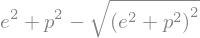

In [169]:
simplify(
    (λ1pow * e**3).subs(a,1)
)

Subcase: $a=2$

In [165]:
simplify(
    (λ1pow*e**4).subs(a,2)
)

Numerical value:

ccl: for $a=2$, λ is **always negative** (cf Xournal++ doc). Also, see numerical value at point (0.5, 0.5) below

TODO: prove that λ≥0 for a≤1 and λ≤0 for a≥1

In [175]:
λ1pow.subs({
    e:0.5,
    p:0.5,
    a:1.5,
})

## Plot

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [180]:
%matplotlib inline

### Contour and 3D plots

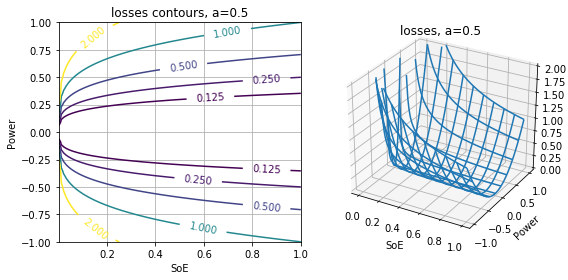

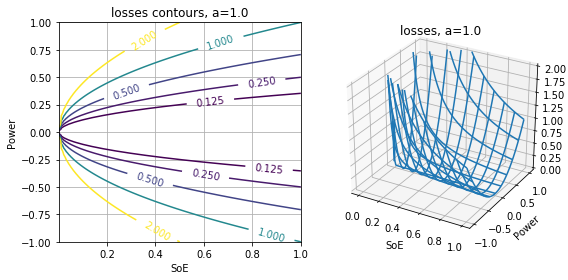

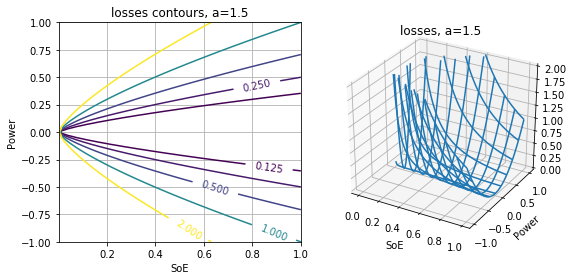

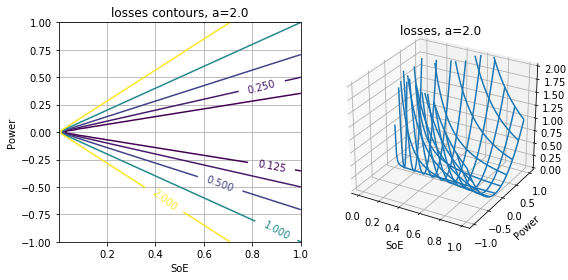

In [233]:
def losses_contour(a):
    n = 100
    x = np.linspace(1e-3, 1, n) # e
    y = np.linspace(-1, 1, n) # p

    X, Y = np.meshgrid(x, y)

    Z = Y**2/X**a
    
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection='3d')
    
    levels = [0.125,0.25, 0.5,1, 2]
    CS = ax1.contour(X, Y, Z, levels)
    ax1.clabel(CS, inline=1, fontsize=10)
    ax1.grid()
    
    x = np.linspace(1e-3, 1, n) # e
    y = np.linspace(-1, 1, n) # p

    X, Y = np.meshgrid(x, y)

    Z = Y**2/X**a
    Z[Z>2.1] = np.nan
    
    ax2.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
    ax2.set_zlim(0,2)
    
    ax1.set(
        title = f'losses contours, a={a}',
        xlabel = 'SoE',
        ylabel = 'Power',
    )
    
    ax2.set(
        title = f'losses, a={a}',
        xlabel = 'SoE',
        ylabel = 'Power',
    )
    
    fig.tight_layout()

losses_contour(0.5)
plt.savefig('losses_3D_0.5.png', dpi=200)
losses_contour(1.0)
plt.savefig('losses_3D_1.0.png', dpi=200)
losses_contour(1.5)
plt.savefig('losses_3D_1.5.png', dpi=200)
losses_contour(2.0)
plt.savefig('losses_3D_2.0.png', dpi=200)

Non convex sublevel sets: $a > 2$

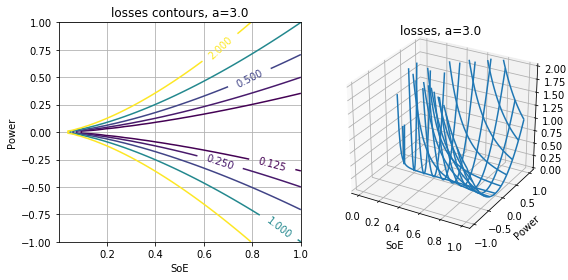

In [234]:
losses_contour(3.0)
plt.savefig('losses_3D_3.0.png', dpi=200)

Interactive plot

In [178]:
%matplotlib qt5

In [179]:
losses_contour(2)

In [235]:
%matplotlib inline

### 2D cuts on lines

because of the property that a convex function evaluated on a line is a 1D convex function

In [205]:
def plot_line_cut(a, ang, e0=0.5, p0=0.5, r = 0.45):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

    n = 100
    x = np.linspace(1e-3, 1, n) # e
    y = np.linspace(-1, 1, n) # p

    X, Y = np.meshgrid(x, y)

    Z = Y**2/X**a
    
    levels = [0.125,0.25, 0.5,1, 2]
    CS = ax1.contour(X, Y, Z, levels)
    ax1.clabel(CS, inline=1, fontsize=10)
    
    
    t = np.linspace(-r, r, 300)
    x = e0 + t*np.cos(ang)
    y = p0 + t*np.sin(ang)
    
    l = y**2/x**a
    ax1.plot(x,y, 'k:')
    ax1.plot(e0,p0, 'ko')

    ax2.plot(t, l)
    ax2.plot(0, p0**2/e0**a, 'ko')
    
    ax1.set(
        title = f'losses contours, a={a}',
        xlabel = 'SoE',
        ylabel = 'Power',
    )
    ax1.grid()
    
    ax2.set(
        title = f'losses cut, a={a}',
        xlabel = 't',
    )
    ax2.grid()
    
    fig.tight_layout()

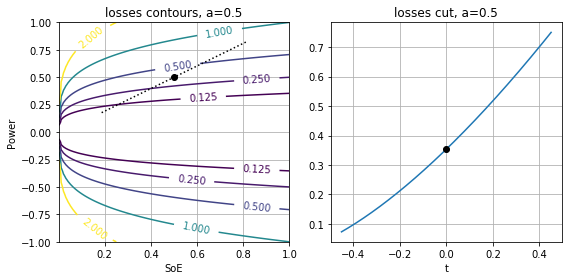

In [220]:
plot_line_cut(0.5, 0.8)
plt.savefig('losses_cut_0.5.png', dpi=200)

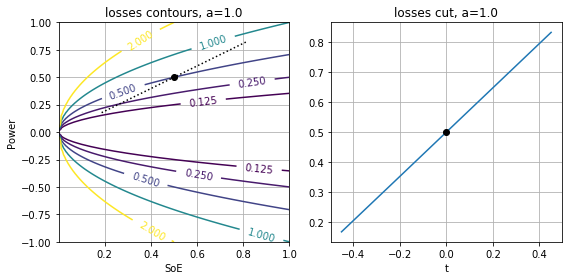

In [236]:
plot_line_cut(1.0, 0.8)
plt.savefig('losses_cut_1.0.png', dpi=200)

Concavity for $a=1.5$

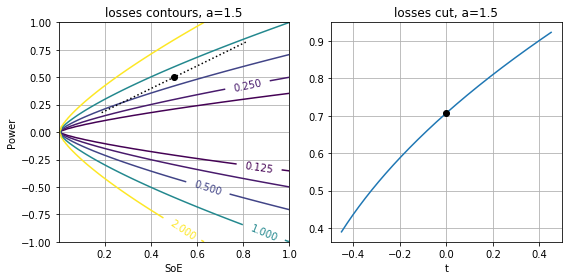

In [219]:
plot_line_cut(1.5, 0.8)
plt.savefig('losses_cut_1.5.png', dpi=200)

Non convexity for $a=2$ (although sublevel sets are convex)

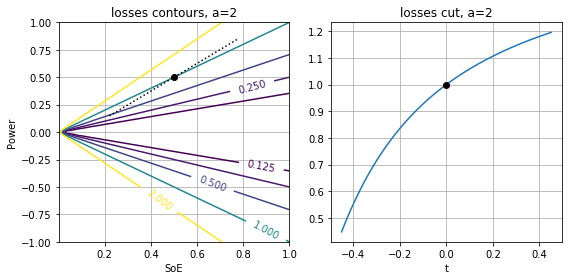

In [229]:
plot_line_cut(2, 0.9)
plt.savefig('losses_cut_2.0.png', dpi=200)